In [1]:
import torch
from datasets import load_dataset, load_from_disk
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer, set_seed
from torch.utils.data import DataLoader, IterableDataset, RandomSampler
from collections import defaultdict
from diffusers import AutoencoderKL
import torch.distributed as dist

from utils import kl_encode, kl_decode, make_grid

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"


In [3]:
ds=load_from_disk("imagenet1k_eqsdxlvae_latents_withShape")
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'label', 'vae_latent', 'caption', 'latent_shape'],
        num_rows: 1188039
    })
    validation: Dataset({
        features: ['image_id', 'label', 'vae_latent', 'caption', 'latent_shape'],
        num_rows: 49165
    })
})

In [4]:
## fix SwayStar123/imagenet1k_eqsdxlvae_latents

# ds=load_dataset("SwayStar123/imagenet1k_eqsdxlvae_latents")

# # load validation split, create empty mock captions
# d_val = load_dataset("parquet", data_files={'validation': 'validation-00000-of-00001.parquet'})
# def zero_capt(item):
#     item["caption"] = ""
#     return item
# d_val = d_val.map(zero_capt, num_proc=12)
# ds["validation"] = d_val["validation"]

# # add aspect ratios
# def calc_ar(item):
#     item["latent_shape"] = torch.Tensor(item["vae_latent"]).shape
#     return item
# ds = ds.map(calc_ar, num_proc=28)

# ds.save_to_disk("imagenet1k_eqsdxlvae_latents_withShape")

# ds.push_to_hub("g-ronimo/imagenet1k_eqsdxlvae_latents")

In [5]:
text_encoder = AutoModel.from_pretrained("answerdotai/ModernBERT-large", torch_dtype=dtype).to(device)
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-large", torch_dtype=dtype)
vae_repo = "KBlueLeaf/EQ-SDXL-VAE"
vae = AutoencoderKL.from_pretrained(vae_repo).to(dtype).to(device)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def custom_collate(batch):
    captions = [item['caption'] for item in batch]
    ae_latents = [item['vae_latent'] for item in batch]
    ae_latent_shapes = [item['latent_shape'] for item in batch]

    return {
        'caption': captions,
        'ae_latent': ae_latents,
        'ae_latent_shape': ae_latent_shapes
    }
    
class ShapeBatchingDataset(IterableDataset):
    def __init__(self, hf_dataset, batch_size, tokenizer, text_enc, ddp=False, num_workers=2, seed=42, buffer_multiplier=20, ):
        self.text_enc, self.tokenizer =  text_enc, tokenizer
        self.dataset = hf_dataset
        self.batch_size = batch_size
        self.seed = seed
        self.buffer_multiplier = buffer_multiplier
        self.prompt_len = 50
        self.ddp = ddp

        if ddp:
            world_size = dist.get_world_size()
            self.num_batches = len(hf_dataset) // (batch_size * world_size)
        else:
            self.num_batches = len(hf_dataset) // batch_size      

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        epoch = 0 
        
        while True:
            if self.ddp: 
                sampler = DistributedSampler(self.dataset, shuffle=True, seed=self.seed+epoch)
            else: 
                sampler = RandomSampler(self.dataset, generator=torch.manual_seed(self.seed+epoch))
            
            self.dataloader = DataLoader(
                self.dataset, self.batch_size * 2, sampler=sampler, prefetch_factor=5, num_workers=2, collate_fn=custom_collate
            )
            
            shape_batches = defaultdict(lambda: {'caption': [], 'ae_latent': []})
            for batch in self.dataloader:
                caption = batch['caption']
                ae_latent = batch['ae_latent']
                ae_latent_shape = batch['ae_latent_shape']

                for i in range(len(caption)):
                    shape_key = tuple(ae_latent_shape[i])
                    shape_batches[shape_key]['caption'].append(caption[i])
                    shape_batches[shape_key]['ae_latent'].append(ae_latent[i])

                    # If enough samples are accumulated for this shape, yield a batch
                    if len(shape_batches[shape_key]['caption']) == self.batch_size:
                        batch = self.prepare_batch(shape_batches[shape_key], shape_key)
                        yield batch
                        shape_batches[shape_key]['caption'] = []
                        shape_batches[shape_key]['ae_latent'] = []
            epoch += 1

    def prepare_batch(self, samples, latent_shape):
        captions = samples["caption"]
        ae_latents = torch.Tensor(samples["ae_latent"])
        # not 100% sure what's happenning here
        ae_latents = ae_latents.to(torch.uint8).view(torch.float8_e5m2).to(dtype).to(device)
        caption_embs, caption_atnmasks = self.encode_prompts(captions)

        return captions, ae_latents, caption_embs, caption_atnmasks

    def encode_prompts(self, prompts):
        prompts_tok = self.tokenizer(
            prompts, padding="max_length", truncation=True, max_length=self.prompt_len, return_tensors="pt"
        )
        with torch.no_grad():
            prompts_encoded = self.text_enc(**prompts_tok.to(self.text_enc.device))
        return prompts_encoded.last_hidden_state, prompts_tok.attention_mask


In [7]:
sbds = ShapeBatchingDataset(ds["train"], batch_size=8, tokenizer=tokenizer, text_enc=text_encoder)
# next(iter(sbds))
len(sbds)

148504

In [8]:
for batch in tqdm(sbds):
    captions, ae_latents, caption_embs, caption_atnmasks = batch
    print(ae_latents.shape)
    break

  0%|                                                | 0/148504 [00:14<?, ?it/s]

torch.Size([8, 4, 28, 36])


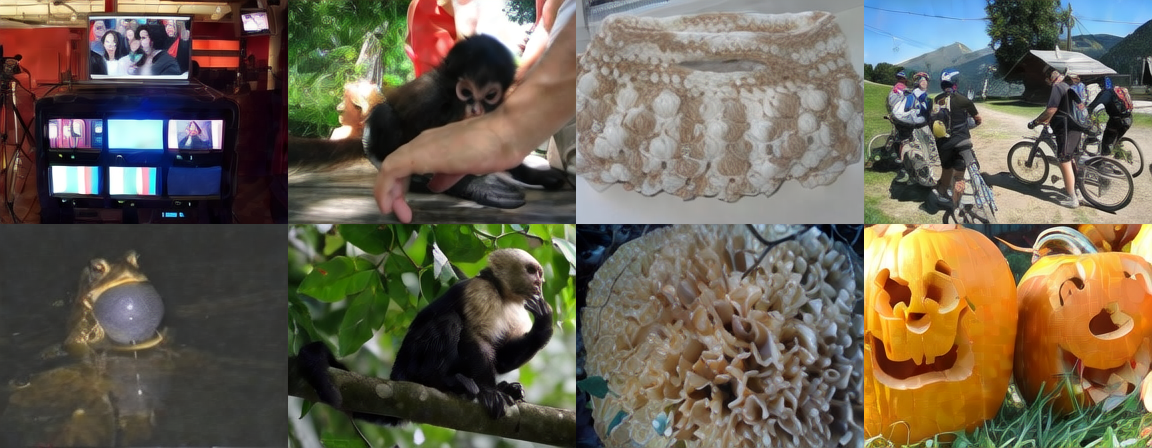

In [9]:
make_grid(kl_decode(ae_latents, vae), 2, 4)

latent dim:  torch.Size([1, 4, 28, 36])
img dim:  (288, 224)
latent space compression factor 8.0 8.0


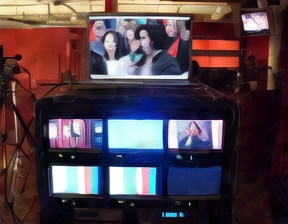

In [26]:
latent = ae_latents[None,0]
_, _, latent_h, latent_w = latent.shape
print("latent dim: ", latent.shape)
img = kl_decode(latent, vae)

print("img dim: ", img.size)
img_w, img_h = img.size

print("latent space compression factor", img_w/latent_w, img_h/latent_h)

img